In [1]:
import re
import numpy as np
import pandas as pd
from termcolor import colored
from collections import Counter
from multiprocessing import Pool # waning: it will raise exception if executed in notebook
from nltk.corpus import stopwords

In [2]:
from tqdm.notebook import tqdm

In [3]:
sw = stopwords.words('english')

# Text from sentences
Example of sentences are taken from `20 newsgroup`

In [4]:
import nltk
from sklearn.datasets import fetch_20newsgroups

In [5]:
train = fetch_20newsgroups(data_home="/Users/flint/Data/sklearn/", subset='train', 
                        remove=('headers', 'footers', 'quotes'),
                        categories=['rec.sport.baseball'])

In [6]:
sentences = []
for doc in train.data:
    for s in nltk.tokenize.sent_tokenize(doc):
        sentences.append(s.lower())

In [7]:
sentences[0]

'\nmaybe it\'s just me, but the combination of those *young* faces peeking out\nfrom under oversized aqua helmets screams "little league" in every fibre of\nmy being...'

# One-hot encoding
Many current NLP systems and techniques treat words as atomic
units - there is no notion of similarity between words, as these are
represented as indices in a vocabulary
(Mikolov et al., 2013)


Suppose that the number of different words in the vocabulary (the vocabulary size) is $V$. To obtain the one-hot vector representation for any word with index $i$, we create a length-$V$ vector with all $0$ s and set the element at position $i$ to $1$

In [8]:
from nltk.tokenize import word_tokenize

In [9]:
corpus = sentences
V = set()
for sentence in corpus:
    for word in word_tokenize(sentence):
        V.add(word)
V = list(V)

In [10]:
# example
print(colored('Vocab size:', attrs=['bold']), len(V))

Vocab size: 8723


In [11]:
V.index('suppose')

3910

In [12]:
def one_hot_encoding(V, word) -> np.array:
    """Return one-hot encoding
    
    Args:
        V(list): Vocabulary, i.e., word list.
        word: word in the vocabulary.
    Returns:
        one_hot_encoding(np.array)
    """
    vec = np.zeros(len(V))
    vec[V.index(word)] = 1.0
    return vec

In [13]:
# example
word1, word2 = V[1], V[2]
vec1, vec2 = one_hot_encoding(V, word1), one_hot_encoding(V, word2)

print(f"{colored('One-hot Encoding', attrs=['bold'])} {word1}:", vec1)
print(f"{colored('One-hot Encoding', attrs=['bold'])} {word2}:", vec2)   

One-hot Encoding strain: [0. 1. 0. ... 0. 0. 0.]
One-hot Encoding revenue: [0. 0. 1. ... 0. 0. 0.]


One-hot encoded vectors are orthonormal. <br/>

For vectors $x, y \in \mathbb{R}^V$ with $x\ne y$, their _similarity_ is always $0$. 

On the contrary, for vectors $x, y \in \mathbb{R}^V$ with $x = y$, their _similarity_ is always $1$.

\begin{equation*}
\frac{x^T \ y}{\|x\| \ \|y\|} \in \{0, 1\}
\end{equation*}

In [14]:
def cosine_similarity(vec1: np.array, vec2: np.array) -> float:
    """Return cosine similarity between two vectors
    
    Args:
        vec1(np.array): vector 1.
        vec2(np.array): vector 2.
    Returns:
        cosine similarity
    """
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [15]:
# example 
print(f"{colored('Cosine similarity (', attrs=['bold'])}{word1}, {word2}{colored(')', attrs=['bold'])}:", 
      cosine_similarity(vec1, vec2))
print(f"{colored('Cosine similarity (', attrs=['bold'])}{word2}, {word1}{colored(')', attrs=['bold'])}:", 
      cosine_similarity(vec2, vec1))
print(f"{colored('Cosine similarity (', attrs=['bold'])}{word1}, {word1}{colored(')', attrs=['bold'])}:", 
      cosine_similarity(vec1, vec1))
print(f"{colored('Cosine similarity (', attrs=['bold'])}{word2}, {word2}{colored(')', attrs=['bold'])}:", 
      cosine_similarity(vec2, vec2))

Cosine similarity (strain, revenue): 0.0
Cosine similarity (revenue, strain): 0.0
Cosine similarity (strain, strain): 1.0
Cosine similarity (revenue, revenue): 1.0


In [16]:
v_play = one_hot_encoding(V, 'play')
v_game = one_hot_encoding(V, 'game')

In [17]:
cosine_similarity(v_play, v_game)

0.0

# Word2Vec: semantic word representations

Word2Vec maps each word to a **low-dimensional continuous vector**, in a way that words that have similar meaning have similar representations.
	
Word2Vec is based on a simple but efficient *feed-forward* neural architecture which is trained with language modeling objective. 

Word2Vec consists of two different architectures: __Skip-gram__ and __Continuous Bag-of-Words__ (CBOW).

## Generating variables

In [18]:
import string

In [19]:
tokens = [[x for x in word_tokenize(t) if x not in sw and x not in string.punctuation] for t in corpus]

In [20]:
# example
print(colored('Text:', attrs=['bold']))
print(corpus[20], end='\n\n')

print(colored('Tokens:', attrs=['bold']))
print(tokens[20])

Text:
finally, i throw all this into a a formula i call defensive contribution, or
dcon :->.

Tokens:
['finally', 'throw', 'formula', 'call', 'defensive', 'contribution', 'dcon']


In [21]:
def build_vocab(token_batches, min_count=15) -> dict:
    '''Build vocabulary and filter rare words.
    
    Args:
        token_batches(list): Token batches.
        min_count(int, optional, default=15): Minimum frequency threshold.
    Returns:
        vocab(dict): Dictionary containing token and frequencies.
    '''
    
    counts = Counter([token for tokens in token_batches for token in tokens])
    vocab = list(counts.keys())
    vocab = {k:v for k, v in counts.items() if v > min_count} # Filtering
    return vocab

vocab = build_vocab(tokens, min_count=10)
vocab_size = len(vocab)

In [22]:
# example
print(colored('Vocab size:', attrs=['bold']), vocab_size, '\n')
print(colored('Vocab(word, frequency):', attrs=['bold']), 
      f"\n  ..., {str({k: vocab[k] for k in sorted(vocab)[100:107]})[1:-1]},  ...".replace(',', ',\n'))

Vocab size: 824 

Vocab(word, frequency): 
  ...,
 '7': 76,
 '70': 12,
 '8': 36,
 '80': 14,
 '89': 11,
 '9': 47,
 '92': 12,
  ...


In [23]:
def mapping(vocab: list) -> tuple:
    '''
    Generate mapping dictionaries.
    
    Args:
        vocab(dict): Dictionary containing token and frequencies.
    Returns:
        token_to_id(dict): Mapping token -> id. 
        id_to_token(dict): Mapping id -> token. 
    '''
    token_to_id = dict()
    id_to_token = dict()

    for i, token in enumerate(vocab):
        token_to_id[token] = i
        id_to_token[i] = token

    return token_to_id, id_to_token

token_to_id, id_to_token = mapping(vocab)

In [24]:
# example
print(colored('Record', attrs=['bold']))
print(token_to_id['pitch'],':', id_to_token[token_to_id['pitch']])

Record
345 : pitch


## Generating training samples

In [25]:
def one_hot_encoding(token_id, vocab_size) -> np.array:
    '''Return one-hot encoding
    
    Args:
        token_id(int): Token id.
        vocab_size(int): Number of token in the dictionary.
    Returns:
        one_hot_encoding(np.array)
    '''
    vec = np.zeros(vocab_size)
    vec[token_id] = 1.0
    return vec

In [26]:
def generate_training_samples(tokens: list, token_to_id: dict, id_to_token: dict, window:int=3) -> list:
    '''Generate training examples for word2vec algorithm.
    
    Args:
        tokens(list): Batch of tokens.
        token_to_id(dict): Mapping token -> id.
        id_to_token(dict): Mapping id -> token.
        window(int, optional, default=5): Number of left and right context words for each target word.
    
    Returns:
        examples(list).
    '''
    
    examples = list()
    n_tokens = len(tokens)

    for i in range(n_tokens):
        if tokens[i] not in token_to_id: continue
            
        target = token_to_id[tokens[i]]
        new_examples = list()

        for j in range(1, window+2):
            # right context
            if i + j < len(tokens):
                if not tokens[i + j] in token_to_id: continue
                context = token_to_id[tokens[i + j]]
                new_examples.append((target, context))
                
            # left context
            if i - j >= 0:
                if not tokens[i - j] in token_to_id: continue
                context = token_to_id[tokens[i - j]]
                new_examples.append((target, context))
            
        examples.append(new_examples)

    return np.asarray(examples, dtype=object)

def generate_multiple_training_samples(token_batches: list, token_to_id: dict, id_to_token: dict, window:int=3, 
                                workers:int = 10):
    '''Generate training example for word2vec algorithm.
    
    Args:
        tokens(list): Batch of tokens.
        token_to_id(dict): Mapping token -> id.
        id_to_token(dict): Mapping id -> token.
        vocab_size(int): Number of token in the dictionary.
        window(int, optional, default=5): Number of left and right context words for each target word.'''
    
    
    with Pool(processes=workers) as p:
        res = p.starmap(generate_training_samples, [(tokens, token_to_id, id_to_token, window) for tokens in token_batches])
    
    return res

window = 3
#samples = generate_multiple_training_samples(tokens, token_to_id, id_to_token, window=3, workers=10) # not working in notebook
samples = [generate_training_samples(t, token_to_id, id_to_token, window=window) for t in tokens]

In [27]:
example = 20

print(colored('Text:', attrs=['bold']))
print(" ".join(tokens[example]), end='\n\n')

print(colored('Window size:', attrs=['bold']), window,'\n')

print(colored('Sliding Window:', attrs=['bold']))
for i in range(len(tokens[example])):
    if i>5: break
    before = " ".join([t for j, t in enumerate(tokens[example]) if j < i-window])
    context_l = colored(" ".join(tokens[example][max(i-window,0):i]), 'blue')
    target = colored(tokens[example][i], 'red')
    context_r = colored(" ".join(tokens[example][i+1:i+window+1]), 'blue')
    after = " ".join(tokens[example][i+window+1:])
    print(f'{i}. ', before + " " + context_l + " " + target + " " + context_r + " " + after,end='\n\n')

training_samples = generate_training_samples(tokens[example], token_to_id, id_to_token, window)[0]
print(colored('Training Example (id, id) - 4:', attrs=['bold']))
print(str(training_samples), '\n\n')

print(colored('Training Example (word, word) - 4:', attrs=['bold']))
print(str(np.array([[id_to_token[i[0]], id_to_token[i[1]]] for i in training_samples])), '\n\n')

print(colored('Training Example (id, id) - 4:', attrs=['bold']))
print(str(np.array([[one_hot_encoding(i[0], vocab_size), 
                    one_hot_encoding(i[1], vocab_size)] 
                    for i in training_samples])))

Text:
finally throw formula call defensive contribution dcon

Window size: 3 

Sliding Window:
0.    finally throw formula call defensive contribution dcon

1.   finally throw formula call defensive contribution dcon

2.   finally throw formula call defensive contribution dcon

3.   finally throw formula call defensive contribution dcon 

4.  finally throw formula call defensive contribution dcon 

5.  finally throw formula call defensive contribution dcon 

Training Example (id, id) - 4:
[(71, 72), (71, 73), (71, 45)] 


Training Example (word, word) - 4:
[['finally' 'throw']
 ['finally' 'call']
 ['finally' 'defensive']] 


Training Example (id, id) - 4:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


# CBOW

## Word2Vec: CBOW

_input to hidden_ 

Input layer: $\mathbf{x} \in \mathbb{R}^{V}$ <br/>
$$
	        \bar{\mathbf{x}} = \frac{1}{C}\sum^C_{c=1} \mathbf{x^{(c)}}
$$
Weights: $W \in \mathbb{R}^{V\times N}$, randomly initialized<br/><br/>
Hidden layer: $\mathbf{h} \in \mathbb{R}^{N}$

$$
\mathbf{h} = \frac{1}{C} \mathbf{W}^T \sum^C_{c=1}  x^{(c)} = \mathbf{W}^T \bar{\mathbf{x}}
$$

Activation function: $\mathbb{I}\text{dentity}$

_hidden to output_

Weights: $\mathbf{W'} \in \mathbb{R}^{N\times V}$, randomly initialized

Output layer: $\mathbf{u} \in \mathbb{R}^V$

$$
\mathbf{u} = \mathbf{W}'^T \mathbf{h} = \frac{1}{C} \sum^C_{c=1} \mathbf{W'}^T \mathbf{W}^T x^{(c)} = \mathbf{W'}^T \mathbf{W}^T \bar{\mathbf{x}}
$$

Activation function: $\mathbb{S}\text{oftmax}$

$$
\mathbf{y} = \mathbb{S}\text{oftmax}(\mathbf{u}) = \mathbb{S}\text{oftmax}(\mathbf{W'}^T\mathbf{W}^T \bar{\mathbf{x}})
$$

_Loss Function_

$$
\mathcal{L} = -\log \mathbb{P}(w_O| w_{c,1}, w_{c,2}, ..., w_{c,C})
\max \log y_{j^*} \nonumber
		     =       \max \log \left(\frac{\exp(u_{j^*})}{\sum^V_{j'=1} \exp(u_{j'})} \right) \nonumber
		      =      \max u_{j^*} - \log \sum^V_{j' = 1} \exp(u_{j'}) \nonumber
		       =     \min \log \sum^V_{j' = 1} \exp(u_{j'}) - u_{j^*}
$$

_Gradient descent_

$$
	    \frac{\partial \mathcal{L}}{\partial \mathbf{W'}} = (\mathbf{W}^T \bar{\mathbf{x}}) \otimes E 
	     \frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \bar{\mathbf{x}} \otimes (\mathbf{W'} E) 
$$

_Backpropagation_

$$
\mathbf{v}_{W}^{(new)} =  \mathbf{v}_{W}^{(old)} - \eta \cdot \frac{\partial \mathcal{L}}{\partial W}
$$

$$
    \mathbf{v}_{W'}^{(new)} =  \mathbf{v}_{W'}^{(old)} - \eta \cdot \frac{\partial \mathcal{L}}{\partial W'}
$$

In [28]:
def softmax(x):
    x = x.astype(float)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [29]:
class Word2Vec:
    
    def __init__(self, sequences:list, vector_size=100):
        """
        Args:
            sequences(list): Token batches.
        """
        self.sequences = sequences
        self.vector_size = vector_size
    
    def __init_network__(self):
        """Initialize the network"""
        
        self.model = {
            "W": np.random.uniform(-1, 1, (self.vocab_size, self.vector_size)),  # input to hidden
            "W'": np.random.uniform(-1, 1, (self.vector_size, self.vocab_size)) # hidden to output
        }
        return self.model
    
    def build_vocab(self, min_count=15) -> dict:
        """Build vocabulary and filter rare words.

        Args:
            min_count(int, optional, default=15): Minimum frequency threshold.
        Returns:
            vocab(dict): Dictionary containing token and frequencies.
        """

        counts = Counter([token for sequence in self.sequences for token in sequence])
        vocab = list(counts.keys())
        vocab = {k:v for k, v in counts.items() if v > min_count} # Filtering

        self.vocab = vocab
        self.vocab_size = len(vocab)
        
        self.token_to_id, self.id_to_token = self.__mapping__()
        
        return vocab
    
    def one_hot_encoding(self, token_id) -> np.array:
        '''Return one-hot encoding

        Args:
            token_id(int): Token id.
        Returns:
            one_hot_encoding(np.array)
        '''
        vec = np.zeros(self.vocab_size)
        vec[token_id] = 1.0
        return vec
    
    def __mapping__(self) -> tuple:
        '''
        Generate mapping dictionaries.

        Returns:
            token_to_id(dict): Mapping token -> id. 
            id_to_token(dict): Mapping id -> token. 
        '''
        token_to_id = dict()
        id_to_token = dict()

        for i, token in enumerate(self.vocab):
            token_to_id[token] = i
            id_to_token[i] = token
        
        return token_to_id, id_to_token

    def __generate_training_samples__(self, tokens: list, window:int=3) -> list:
        '''Generate training examples for word2vec algorithm.

        Args:
            tokens(list): Batch of tokens.
            window(int, optional, default=3): Number of left and right context words for each target word.

        Returns:
            examples(list).
        '''

        examples = list()
        n_tokens = len(tokens)

        for i in range(n_tokens):
            if tokens[i] not in self.token_to_id: continue

            target = self.token_to_id[tokens[i]]
            X, y = list(), np.array(self.one_hot_encoding(target))

            for j in range(1, window+2):
                # right context
                if i + j < len(tokens):
                    if not tokens[i + j] in self.token_to_id: continue
                    context = self.token_to_id[tokens[i + j]]
                    X.append(self.one_hot_encoding(context))

                # left context
                if i - j >= 0:
                    if not tokens[i - j] in self.token_to_id: continue
                    context = self.token_to_id[tokens[i - j]]
                    X.append(self.one_hot_encoding(context))

            examples.append((np.mean(X, axis=0), y))

        return np.asarray(examples, dtype=object)

    def __build_training_samples__(self, window:int=3, workers:int = 10):
        '''Generate training example for word2vec algorithm.

        Args:
            vocab_size(int): Number of token in the dictionary.
            window(int, optional, default=5): Number of left and right context words for each target word.'''


        #with Pool(processes=workers) as p:
        #     res = p.starmap(self.__generate_training_samples__, [(tokens, window) for tokens in self.sequences])

        #return res
        for tokens in self.sequences:
            for sample in self.__generate_training_samples__(tokens, window=window):
                target, context = sample[1], sample[0]
                yield target, context
    
    def __forward_prop__(self, x):
    
        h = np.dot(self.model['W'].T, x)
        u = np.dot(self.model["W'"].T, h)
        y_pred = softmax(u)

        return y_pred, h, u
    
    def __backward_prop__(self, y_pred, h, target, context, learning_rate):
        total_error = self.__calculate_error__(y_pred, target)
        
        derivatives = dict()
        derivatives["∂L/∂W"] = np.outer(target, np.dot(self.model["W'"], total_error.T))
        derivatives["∂L/∂W'"] = np.outer(h, total_error)

        # Update weights
        self.model["W"] = self.model["W"] - (learning_rate * derivatives["∂L/∂W"])
        self.model["W'"] = self.model["W'"] - (learning_rate * derivatives["∂L/∂W'"])

    def __calculate_error__(self, y_pred, y):
        return y_pred - y
        #return np.sum([y_pred - self.one_hot_encoding(index) for index in np.where(context == 1)[0]], axis=0)
    
    def __calculate_loss__(self, u, target):
        u = u.astype(float)
        return -u[target==1][0] + np.log(np.sum(np.exp(u)))
        #return -u[context==1].sum() + len(np.where(context==1)[0]) *np.log(np.sum(np.exp(u)))
    
    def train(self, window:int=3, workers:int=10, epochs:int=25, learning_rate:float=0.01):
        
        self.__init_network__()

        #For analysis purposes
        epoch_loss = []
        weights_1 = []
        weights_2 = []

        for epoch in tqdm(range(epochs)):
            loss = 0

            for target, context in self.__build_training_samples__(window, workers=10):
                y_pred, h, u = self.__forward_prop__(target)
                self.__backward_prop__(y_pred, h, target, context, learning_rate)

                loss_temp = self.__calculate_loss__(u,target)
                loss += loss_temp

            epoch_loss.append( loss )
            weights_1.append(self.model['W'])
            weights_2.append(self.model["W'"])

        self.epoch_loss = epoch_loss
        return epoch_loss, np.array(weights_1), np.array(weights_2)

In [30]:
w = Word2Vec([x for x in tokens if 'game' in x][:50], vector_size=6)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=25, learning_rate=0.01)

  0%|          | 0/25 [00:00<?, ?it/s]

In [31]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, token_to_id, id_to_token, k=10):
    idx = token_to_id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id_to_token[i], dists[i]) for i in ind]
    return out

sim_matrix = get_distance_matrix(w.model["W"], 'cosine')
for word in ['game', 'bat', 'play']:
    print(word, [t[1] for t in get_k_similar_words(word, sim_matrix, w.token_to_id, w.id_to_token)], "\n")

game ['however', 'hundley', '10/1', 'yeah', 'milwaukee', 'roberts', 'said', 'redding', 'things', 'problems'] 

bat ['days', 'redding', 'cubs', 'took', '2-run', 'handers', 'pitching', 'cinci', 'mahaffey', '17-8'] 

play ['eighth', 'kill', 'maintain', 'hoyt', 'doubleheader', 'stiffness', 'shoulder', 'saberhagen', '1st', 'no-hitter'] 



In [32]:
w.model['W'].shape

(495, 6)

In [34]:
v_game = w.model['W'][token_to_id['game']]
v_play = w.model['W'][token_to_id['baseball']]

In [35]:
np.dot(v_game, v_play)/(np.linalg.norm(v_game)*np.linalg.norm(v_play))

0.04419109411909804

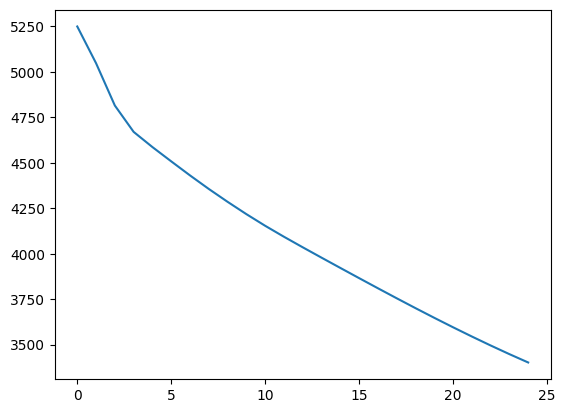

In [36]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [ ]:
w = Word2Vec([x for x in tokens if 'game' in x][:50], vector_size=6)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=150, learning_rate=0.01)

In [ ]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, token_to_id, id_to_token, k=20):
    idx = token_to_id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id_to_token[i], dists[i]) for i in ind]
    return out

sim_matrix = get_distance_matrix(w.model["W"], 'cosine')
for word in ['game', 'bat', 'play']:
    print(word, [t[1] for t in get_k_similar_words(word, sim_matrix, w.token_to_id, w.id_to_token)], "\n")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [37]:
w = Word2Vec([i for i in tokens if 'game' in i][:50], vector_size=10)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=50, learning_rate=0.03)

  0%|          | 0/50 [00:00<?, ?it/s]

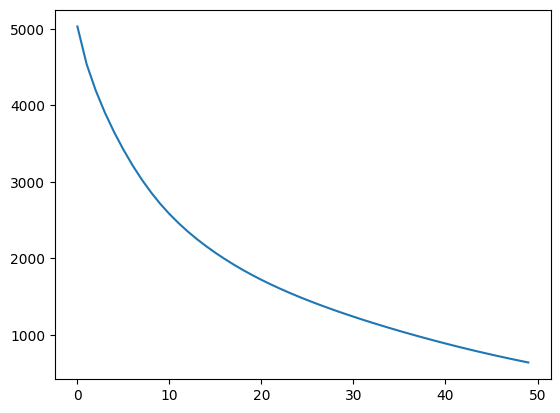

In [38]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [39]:
w.epoch_loss

[5031.422786479648,
 4540.507624253903,
 4192.964761517667,
 3902.4180923501467,
 3649.0788488138423,
 3422.0572571046246,
 3216.4355591136223,
 3030.80728680187,
 2864.190685160989,
 2714.9590990532924,
 2581.4535233306046,
 2461.251694744778,
 2351.9802045317024,
 2251.963403879688,
 2159.791701221294,
 2074.220161830091,
 1994.2926745974196,
 1919.3817796778037,
 1849.0848326474186,
 1783.0688992357523,
 1720.9668140319534,
 1662.3649436582652,
 1606.8486504035814,
 1554.0466780772597,
 1503.6469683704677,
 1455.390961947717,
 1409.0607228962929,
 1364.4669756450771,
 1321.440959706358,
 1279.8305284833139,
 1239.4996666885113,
 1200.329895111418,
 1162.2217731153748,
 1125.0951408174706,
 1088.8877187949624,
 1053.552530702974,
 1019.0548979165807,
 985.3695932936729,
 952.4784486218085,
 920.3684820412524,
 889.0304901859312,
 858.45800748806,
 828.646535406754,
 799.5929618894684,
 771.2951125097522,
 743.7513932923475,
 716.9604991269537,
 690.9211708441467,
 665.6319894492973,


## Gensim

In [40]:
from gensim.models import Word2Vec

In [41]:
train = fetch_20newsgroups(data_home="/Users/flint/Data/sklearn/", subset='train', 
                        remove=('headers', 'footers', 'quotes'))

In [42]:
sentences = []
for doc in train.data:
    for s in nltk.tokenize.sent_tokenize(doc):
        sentences.append(s.lower())

In [43]:
tokens = [[x for x in word_tokenize(t) if x not in sw and x not in 
           string.punctuation] for t in sentences]

In [44]:
model = Word2Vec(sentences=tokens, vector_size=50, 
                window=6, epochs=25, min_count=1, workers=4)

In [45]:
model.wv.similar_by_word('gun')

[('guns', 0.7860516905784607),
 ('weapon', 0.74169921875),
 ('handgun', 0.7244267463684082),
 ('weapons', 0.7018080949783325),
 ('firearms', 0.6921926736831665),
 ('negligent', 0.6900681853294373),
 ('control', 0.6826080679893494),
 ('the-big-lie', 0.6823912262916565),
 ('owning', 0.6740325689315796),
 ('assault', 0.6720585227012634)]

In [46]:
model.wv.similarity('play', 'game')

0.6592532

### Base model and specialized models
Word embedding may be used also to get the specific shift of words among different corpora

#### Create a global model

In [47]:
import copy

In [48]:
politics = copy.deepcopy(model)
religion = copy.deepcopy(model)
sports = copy.deepcopy(model)

In [49]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [50]:
politics_classes = ['talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc']
religion_classes = ['alt.atheism', 'soc.religion.christian', 'talk.religion.misc']
sports_classes = ['rec.sport.baseball', 'rec.sport.hockey']
politics_docs = []
religion_docs = []
sports_docs = []
for i, text in enumerate(train.data):
    class_label = train.target_names[train.target[i]]
    for sentence in nltk.tokenize.sent_tokenize(text):
        tokens = [x for x in word_tokenize(sentence) if x not in sw and x not in string.punctuation]
        if class_label in politics_classes:
            politics_docs.append(tokens)
        elif class_label in religion_classes:
            religion_docs.append(tokens)
        elif class_label in sports_classes:
            sports_docs.append(tokens)
        else:
            pass 

#### Update the model for specific corpora to obtain specific fine-tuned models

In [51]:
politics.train(politics_docs, total_examples=model.corpus_count, epochs=model.epochs)

(4726677, 7300150)

In [52]:
religion.train(religion_docs, total_examples=model.corpus_count, epochs=model.epochs)

(3467802, 4920050)

In [53]:
sports.train(sports_docs, total_examples=model.corpus_count, epochs=model.epochs)

(2236371, 3605400)

#### Compare the models

In [54]:
politics.wv.most_similar('church')

[('christian', 0.8073882460594177),
 ('catholic', 0.8048372268676758),
 ('doctrine', 0.7640640139579773),
 ('orthodox', 0.7630952596664429),
 ('theology', 0.7578917741775513),
 ('doctrines', 0.7494341135025024),
 ('priests', 0.7491365671157837),
 ('teachings', 0.7437117695808411),
 ('priesthood', 0.7406182885169983),
 ('teaching', 0.7399969100952148)]

In [55]:
religion.wv.most_similar('church')

[('wedding', 0.7001965641975403),
 ('lds', 0.670336127281189),
 ('jewish', 0.6686580777168274),
 ('pastor', 0.6647034287452698),
 ('coptic', 0.6643226742744446),
 ('churches', 0.6612595319747925),
 ('priests', 0.6583835482597351),
 ('meetings', 0.6565646529197693),
 ('catholic', 0.6541749835014343),
 ('masonry', 0.6523134708404541)]

In [56]:
sports.wv.most_similar('church')

[('christian', 0.8116110563278198),
 ('catholic', 0.7981311082839966),
 ('doctrine', 0.7892449498176575),
 ('orthodox', 0.779527485370636),
 ('fathers', 0.7786216735839844),
 ('doctrines', 0.7764530777931213),
 ('theology', 0.769747257232666),
 ('teachings', 0.7687129378318787),
 ('heresy', 0.7642151117324829),
 ('nicea', 0.7595013976097107)]

In [57]:
religion.wv.similarity('church', 'person')

0.33499062

In [58]:
politics.wv.similarity('church', 'person')

0.42561188

In [59]:
sports.wv.similarity('church', 'person')

0.4870929

**Shift from global model**

In [60]:
word = 'church'
g, p, r, s = model.wv.get_vector(word), politics.wv.get_vector(word), religion.wv.get_vector(word), sports.wv.get_vector(word)

In [61]:
np.dot(g, p)/(np.linalg.norm(g)*np.linalg.norm(p))

0.98825336

In [62]:
np.dot(g, r)/(np.linalg.norm(g)*np.linalg.norm(r))

0.9009634

In [63]:
np.dot(g, s)/(np.linalg.norm(g)*np.linalg.norm(s))

1.0

### Visualize

In [64]:
from sklearn.manifold import TSNE
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid")

In [65]:
selected_words = [
    'play', 'game', 'win', 'defeat', 'lose', 'gun', 'people', 'field'
]
P = np.array([politics.wv.get_vector(w) for w in selected_words])
R = np.array([religion.wv.get_vector(w) for w in selected_words])
S = np.array([sports.wv.get_vector(w) for w in selected_words])

In [66]:
collection = {'Politics': P, 'Religion': R, 'Sports': S}
reduced = {}
for k, v in collection.items():
    tsne = TSNE(n_components=2, perplexity=6)
    reduced[k] = tsne.fit_transform(v)

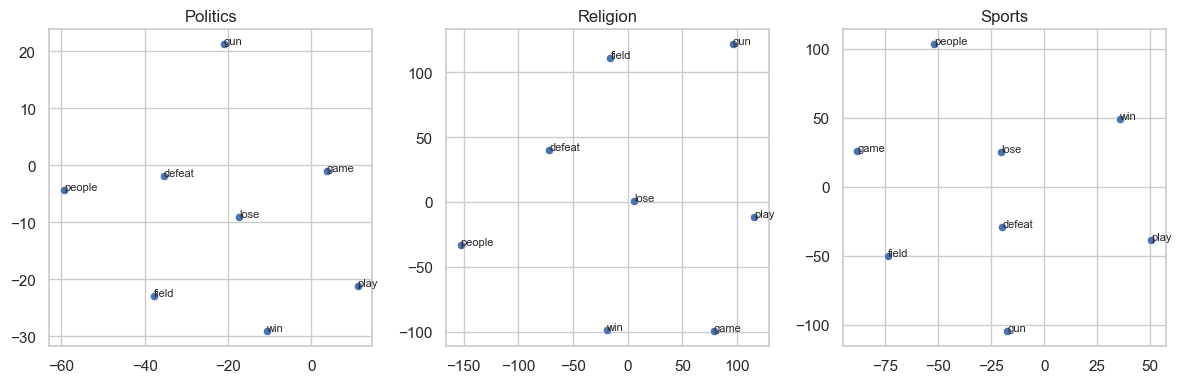

In [67]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
for i, (k, v) in enumerate(reduced.items()):
    sns.scatterplot(x=v[:,0], y=v[:,1], ax=ax[i])
    for j, w in enumerate(selected_words):
        ax[i].text(v[j][0], v[j][1], w, fontsize=8)
    ax[i].set_title(k)
plt.tight_layout()
plt.show()